The model training history indicates some improvements in accuracy and loss over the epochs, but there is still a significant gap between training and validation performance, suggesting potential overfitting or insufficient learning capacity.

Here are some suggestions to improve the performance of your model:

Unfreeze More Layers: Gradually unfreeze layers of the base model to allow more fine-tuning during training.
Adjust Learning Rate: Sometimes, the learning rate needs to be adjusted to ensure better convergence. You can use a learning rate scheduler or try different learning rates.
Data Augmentation: Improve the generalization of your model by augmenting your training data.
More Epochs: Training for more epochs might help the model to learn better.
Regularization: Add dropout layers to prevent overfitting.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np

In [3]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Thesis/RealWaste/Training',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/Thesis/RealWaste/Testing',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

num_classes = len(train_generator.class_indices)
# Extract class indices and class names from the training generator
class_indices = train_generator.class_indices
index_to_class = {v: k for k, v in class_indices.items()}
print("Class indices:", class_indices)

Found 3440 images belonging to 5 classes.
Found 864 images belonging to 5 classes.
Class indices: {'Glass': 0, 'Metal': 1, 'Organic': 2, 'Paper': 3, 'Plastic': 4}


In [4]:
# Define and compile the ResNet50 model
base_model = ResNet50(include_top=False, weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout for regularization
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Unfreeze some layers of the base model
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Learning rate scheduler
def lr_schedule(epoch, lr):
    if epoch > 5:
        lr = lr * 0.1
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=20,
    callbacks=[lr_scheduler]
)

# Evaluate the model on the validation set
loss, accuracy = model.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)
print('Validation loss:', loss)
print('Validation accuracy:', accuracy)

94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/20
107/107 [==============================] - 1354s 12s/step - loss: 0.5385 - accuracy: 0.8025 - val_loss: 3.1364 - val_accuracy: 0.2014 - lr: 1.0000e-04
Epoch 2/20
107/107 [==============================] - 81s 756ms/step - loss: 0.2291 - accuracy: 0.9243 - val_loss: 6.6067 - val_accuracy: 0.2014 - lr: 1.0000e-04
Epoch 3/20
107/107 [==============================] - 81s 755ms/step - loss: 0.1533 - accuracy: 0.9466 - val_loss: 10.6175 - val_accuracy: 0.2465 - lr: 1.0000e-04
Epoch 4/20
107/107 [==============================] - 80s 749ms/step - loss: 0.1082 - accuracy: 0.9654 - val_loss: 5.3105 - val_accuracy: 0.2199 - lr: 1.0000e-04
Epoch 5/20
107/107 [==============================] - 79s 734ms/step - loss: 0.1022 - accuracy: 0.9616 - val_loss: 3.2466 - val_accuracy: 0.2685 - lr: 1.0000e-04
Epoch 6/20
107/107 [==============================] - 83s 774ms/step - loss: 0.1173 - accuracy: 0.9621 - val_loss: 8.4868 - 

In [5]:
# Save the model
model.save('/content/drive/MyDrive/Thesis/garbage_classifier.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [6]:
from google.colab import files
files.download('/content/drive/MyDrive/Thesis/garbage_classifier.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

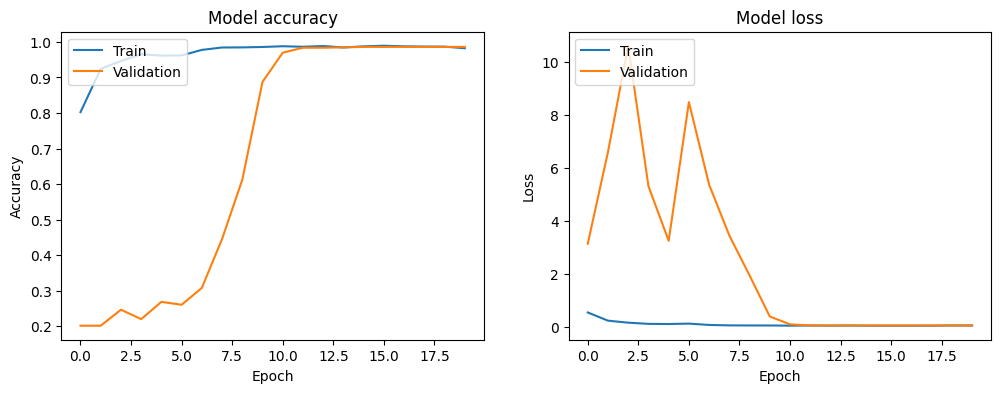

In [7]:
# Visualize training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [8]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Found 864 images belonging to 5 classes.
27/27 [==============================] - 8s 229ms/step


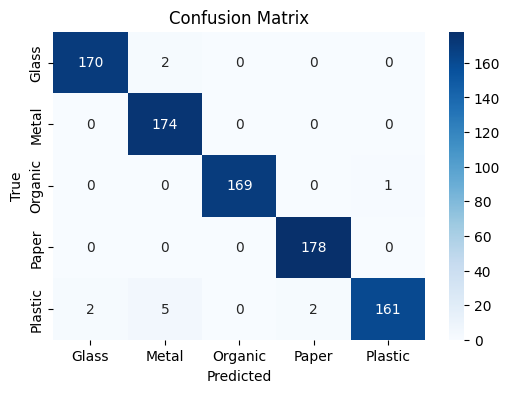

              precision    recall  f1-score   support

       Glass       0.99      0.99      0.99       172
       Metal       0.96      1.00      0.98       174
     Organic       1.00      0.99      1.00       170
       Paper       0.99      1.00      0.99       178
     Plastic       0.99      0.95      0.97       170

    accuracy                           0.99       864
   macro avg       0.99      0.99      0.99       864
weighted avg       0.99      0.99      0.99       864



In [11]:
# Load the trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/Thesis/garbage_classifier.h5')

# Set path to your validation dataset
val_dir = '/content/drive/MyDrive/Thesis/RealWaste/Testing'

# ImageDataGenerator for validation data
val_datagen = ImageDataGenerator(rescale=1./255)

# Create validation generator
validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Get the ground truth labels
y_true = validation_generator.classes

# Predict the classes
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Get class labels
class_labels = list(validation_generator.class_indices.keys())

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

